<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/Copy_of_jaxtrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib.pyplot as plt

In [17]:
class SimpleMLP(nn.Module):
    features:Sequence[int]

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            if i != len(self.features)-1:
                x=nn.relu(x)
        return x

In [18]:
layer_sizes=[64,256,256,256]
learning_rate=1e-5
epochs=300000
model=SimpleMLP(features=layer_sizes)
temp=jnp.ones(2)
params=model.init(random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)

In [19]:
def npy_loader(path):
    return jnp.load(path)

In [20]:
@jit
def mse_loss(params,x,y_ref):
    preds=model.apply(params,x)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [21]:
@jit
def train_step(params,opt_state,x,y_ref):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [22]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)-1],:]
        y_batch=y_train[order[32*j:32*(j+1)-1],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch)
        train_loss=train_loss+loss
    return train_loss,params

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
raw_input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
input_result=jnp.log(raw_input_result)
x_train=jnp.stack((input_data[0:800,0],input_data[0:800,2]),axis=1)
y_train=input_result[0:800,:]
x_validate=jnp.stack((input_data[800:900,0],input_data[800:900,2]),axis=1)
y_validate=input_result[800:900,:]

1000 8.643625e-05
2000 8.459945e-06
3000 3.607019e-06
4000 2.9793912e-06
5000 2.5245818e-06
6000 2.0333937e-06
7000 1.6838869e-06
8000 2.0486702e-06
9000 2.1610992e-06
10000 1.5187533e-06
11000 1.3624158e-06
12000 1.2152493e-06
13000 1.1035607e-06
14000 2.260934e-06
15000 1.4565303e-06
16000 1.4747683e-06
17000 9.615061e-07
18000 8.9907604e-07
19000 9.0528e-07
20000 9.133126e-07
21000 9.188964e-07
22000 9.10267e-07
23000 9.225786e-07
24000 9.361308e-07
25000 9.1435015e-07
26000 9.047199e-07
27000 9.3709923e-07
28000 9.2910636e-07
29000 9.2426626e-07
30000 9.3114926e-07
31000 9.24661e-07
32000 9.210729e-07
33000 9.143559e-07
34000 9.2190584e-07
35000 9.0164826e-07
36000 9.548593e-07
37000 9.4066104e-07
38000 9.367463e-07
39000 9.281066e-07
40000 9.1818436e-07
41000 9.0002334e-07
42000 8.965243e-07
43000 8.9320133e-07
44000 8.9473843e-07
45000 8.897152e-07
46000 8.7846377e-07
47000 1.0381868e-06
48000 1.1184353e-06
49000 1.1865379e-06
50000 1.2179034e-06
51000 1.2215487e-06
52000 1.29439

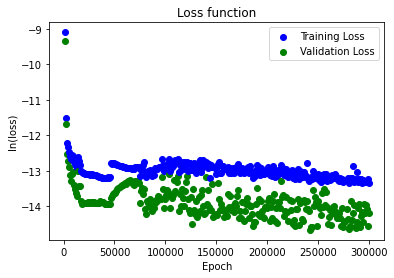

In [25]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order)
    if i % 1000 == 999:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate)
        print((i+1),validate_loss)
        plt.scatter((i+1),jnp.log(train_loss),c='b')
        plt.scatter((i+1),jnp.log(validate_loss),c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks",target=state,step=0,overwrite=True)
plt.xlabel("Epoch")
plt.ylabel("ln(loss)")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")
drive.flush_and_unmount()

In [26]:
x_test=jnp.stack((input_data[900:1000,0],input_data[900:1000,2]),axis=1)
y_test=raw_input_result[900:1000,:]
y_pred=jnp.exp(model.apply(params,x_test))
print(y_pred)
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")

[[0.01185214 0.01206065 0.01227298 ... 0.97635496 0.98850614 1.0001982 ]
 [0.01269078 0.01291261 0.01314655 ... 0.97937346 0.9897418  1.0004606 ]
 [0.01396163 0.01421279 0.01446752 ... 0.9840318  0.99220395 1.0002074 ]
 ...
 [0.01429177 0.01454235 0.01479718 ... 0.98386043 0.9918452  1.0003012 ]
 [0.01575008 0.01603103 0.01631627 ... 0.9872474  0.9938792  1.000743  ]
 [0.01207426 0.01229169 0.01251322 ... 0.97745264 0.988731   1.0002598 ]]
Max error = 0.65140724 %
